## Face mask detetion model

### 1. Introduction
Dataset is available here: https://www.kaggle.com/datasets/wobotintelligence/face-mask-detection-dataset/code<br>
The dataset is provided by Wobot Intelligence a, which provides artificial intelligence-based solution for video analytics.<br>
The dataset has a size over 2.6gb and contains 6'024 images.

#### 2. Data Exploration
- Only 4'326 images are labeled with binary class "face_with_mask", "face_no_mask". These images can be used for train and validation set. For a binary classification this is sufficient.<br>
- The rest of the images 1'698 (6'024 - 4'326) can be used for experimental test inputs. However, since it is not labeled, the validation if correct or not has to be done by human intelligence.

In [330]:
# Imports
import os
import json

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [331]:
# Use of external model for face detection (Used for deployment & testing - face boxes are not labeled in test images)
cvNet = cv2.dnn.readNetFromCaffe('face_detection/architecture.txt',
                                 'face_detection/weights.caffemodel')

In [332]:
# Auxialiary functions

def get_JSON(path):
    with open(path,'r') as f:
        return json.load(f)

In [333]:
# Dataset paths

images = "dataset_face_masks/Medical mask/Medical mask/Medical Mask/images"
images_annotations = "dataset_face_masks/Medical mask/Medical mask/Medical Mask/annotations"


#### Images
- There is a total of 6'024 images, but only 4'326 are labeled.

In [334]:
# Number of images
print(f"#Total Images: {len(os.listdir(images))}")

# Labeled in metadata:
print(f"#Labeled Images: {len(os.listdir(images_annotations))}")

#Total Images: 6024
#Labeled Images: 4326


#### Images
Every image has a different size, below is shown an example of an image.

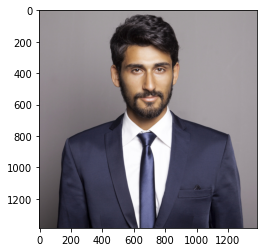

In [335]:
img = plt.imread(os.path.join(images,"1801.jpg"))

plt.imshow(img)

#### Images_annotations
Every image has its own json file with the following important attributes.<br>
For us useful is
- classname (binary) [face_with_mask,face_no_mask]
- BoundingBox -> Rectangle in Pixels around the face

In [336]:
img_annotation = get_JSON(os.path.join(images_annotations,"1801.jpg.json"))
rectangle = img_annotation["Annotations"][0]["BoundingBox"]
face_mask = 1 if img_annotation["Annotations"][0]["classname"]=="face_with_mask" else 0

print(f"Image Annotation: {img_annotation}")
print(f"Rectangle: with left upper point P1(x1:{rectangle[0]},y1:{rectangle[1]}) and right bottom point P2(x2:{rectangle[2]},y2:{rectangle[3]})")
print(f"Face mask (1=yes,0=no): {face_mask}")

Image Annotation: {'FileName': '1801.jpg', 'NumOfAnno': 1, 'Annotations': [{'isProtected': False, 'ID': 924868908868875136, 'BoundingBox': [451, 186, 895, 697], 'classname': 'face_no_mask', 'Confidence': 1, 'Attributes': {}}]}
Rectangle: with left upper point P1(x1:451,y1:186) and right bottom point P2(x2:895,y2:697)
Face mask (1=yes,0=no): 0


#### Image with Rectancle

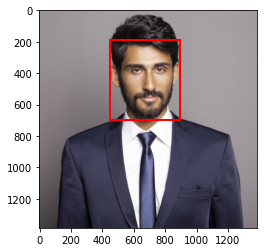

In [337]:
fig,ax = plt.subplots(1)
ax.imshow(img)
rect = patches.Rectangle((rectangle[0],rectangle[1]),rectangle[2]-rectangle[0],rectangle[3]-rectangle[1],linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

#### Cropping face
- The idea is to only get the reactangle of the face for training and then specifically and crop it out.
- Advantage: The model can be trained highly precise and multiple faces per images (in testing) can be identified
- Disadvantage: Takes away the performance, especially to, when the model is deployed in a webservice, because we won't have the rectanle attribute anymore, but we have to implement "face recognition" somehow. Luckily there is a library called mtcnnm (DL-model), which can do this additional preprocessing step in deployment for us.

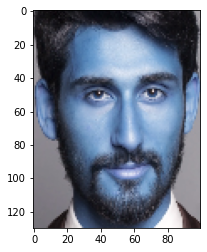

In [338]:
# TUBPLE head size (width, length)
IMG_SIZE=(100,130) # width smaller than length of face, therefore 100:130


img_grey = cv2.imread(os.path.join(images,"1801.jpg"))
img_grey_cropped = img_grey[rectangle[1]:rectangle[3],rectangle[0]:rectangle[2]]
img_grey_cropped_resized = cv2.resize(img_grey_cropped,IMG_SIZE)

fig,ax = plt.subplots(1)
ax.imshow(img_grey_cropped_resized)
plt.show()

#### 3. Preprocessing

In [339]:
def get_dict_images_annotations():
    dict_images_annotations = dict()
    for el in os.listdir(images_annotations):
        rectangle = get_JSON(os.path.join(images_annotations,el))["Annotations"][0]["BoundingBox"]
        face_mask = 1 if get_JSON(os.path.join(images_annotations,el))["Annotations"][0]["classname"]=="face_with_mask" else 0
        dict_images_annotations[el[:-5]]=[face_mask,rectangle]
    return dict_images_annotations

In [340]:
# Top 10 items of dict_imgages_annotactions
list(get_dict_images_annotations().items())[:10]

[('1801.jpg', [0, [451, 186, 895, 697]]),
 ('1802.jpg', [1, [110, 71, 273, 272]]),
 ('1803.jpg', [1, [126, 75, 303, 333]]),
 ('1804.jpg', [1, [112, 113, 262, 307]]),
 ('1805.jpg', [1, [728, 180, 853, 336]]),
 ('1806.jpg', [1, [509, 184, 617, 313]]),
 ('1807.jpg', [0, [700, 165, 1802, 1525]]),
 ('1808.jpg', [0, [80, 243, 882, 1158]]),
 ('1809.jpg', [0, [915, 78, 1419, 742]]),
 ('1810.jpg', [0, [99, 212, 233, 373]])]

In [341]:
def transform_image(image,rectangle,img_size):
    """
    Cropping the faces of the images from images and resize to (100,130)
    """
    if rectangle is not None:
        img = cv2.imread(os.path.join(images, image))
        img_cropped = img[rectangle[1]:rectangle[3], rectangle[0]:rectangle[2]]
        return cv2.resize(img_cropped, img_size)

In [342]:
# Function to join images with labels

def get_datasets(img_size,random_seed, split_train_validation):
    X = list()
    y = list()
    X_test_list = list() # Not labeled images
    np.random.seed(random_seed)
    dict_annotations = get_dict_images_annotations()

    img_list = os.listdir(images)
    np.random.shuffle(img_list)
    split_size = int(len(list(dict_annotations.keys()))*split_train_validation)

    for image in img_list:
        if image in dict_annotations.keys():
            X.append(transform_image(image,dict_annotations[image][1],img_size)) # tuple (image,label)
            y.append(dict_annotations[image][0])
        else:
            X_test_list.append(image)

    X_train = np.array(X[:split_size])
    X_val = np.array(X[split_size:])
    y_train = np.array(y[:split_size])
    y_val = np.array(y[split_size:])

    return X_train, y_train, X_val, y_val, X_test_list

In [343]:
# PARAMETERS
IMG_SIZE = (124,124) # width smaller than length of face, therefore 100:130
RANDOM_INT = 7
SPLIT_TRAIN_VALIDATION = 0.8

# GET full dataset with labeled images
X_train, y_train, X_val, y_val, X_test_list = get_datasets(IMG_SIZE,RANDOM_INT,SPLIT_TRAIN_VALIDATION)

In [344]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(3460, 124, 124, 3)
(3460,)
(866, 124, 124, 3)
(866,)


In [346]:
# Values generator for Tensorflow DL-model
def train_val_generators(X_train, y_train, X_val, y_val):

    # np.expand_dims, RGB color dimensions is either 3 for color or 1 for grey-scale
    #X_train = np.expand_dims(X_train,axis=3)
    #X_val = np.expand_dims(X_val,axis=3)

    # Normalize pixel values
    train_datagen = ImageDataGenerator(rescale = 1./255.,
                                       featurewise_center=False,
                                       samplewise_center=False,
                                       featurewise_std_normalization=False,
                                       samplewise_std_normalization=False,
                                       zca_whitening=False,
                                       rotation_range=20,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       horizontal_flip=True,
                                       vertical_flip=False)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Datastream generators for TF
    train_generator = train_datagen.flow(x=X_train,
                                       y=y_train,
                                       batch_size=32)

    validation_generator = validation_datagen.flow(x=X_val,
                                                 y=y_val,
                                                 batch_size=256)


    return train_generator, validation_generator

In [347]:
train_generator, validation_generator = train_val_generators(X_train, y_train, X_val, y_val)

In [348]:
print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (3460, 124, 124, 3)
Labels of training generator have shape: (3460,)
Images of validation generator have shape: (866, 124, 124, 3)
Labels of validation generator have shape: (866,)


#### 4. Modelling, Training

In [349]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_loss') is not None and logs.get('val_loss') < 0.3:
            print("\nReached 0.3 validation loss so cancelling training!")
            self.model.stop_training = True

In [350]:
# CNN model
def create_model():

    model = tf.keras.models.Sequential([
        # 1. Convolution
        tf.keras.layers.Conv2D(32,(3,3),input_shape=(124,124,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(5,5),

        # 2. & 3. Convolution
        tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
        tf.keras.layers.Conv2D(128,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(5,5),

        # 4. Flatten
        tf.keras.layers.Flatten(),

        # 5. Dense Layer and Binary Output
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy'])

    return model

In [351]:
# Create model
model = create_model()

# Custom callback
callbacks = myCallback()

# Train model
history = model.fit(train_generator,
                    epochs=60,
                    validation_data=validation_generator,
                    callbacks=[callbacks]
                    )

Epoch 1/60
109/109 [==============================] - 11s 98ms/step - loss: 0.5929 - accuracy: 0.6835 - val_loss: 0.4997 - val_accuracy: 0.7667
Epoch 2/60
109/109 [==============================] - 10s 95ms/step - loss: 0.5129 - accuracy: 0.7480 - val_loss: 0.4301 - val_accuracy: 0.7979
Epoch 3/60
109/109 [==============================] - 11s 97ms/step - loss: 0.4888 - accuracy: 0.7740 - val_loss: 0.4406 - val_accuracy: 0.7933
Epoch 4/60
109/109 [==============================] - 10s 91ms/step - loss: 0.4773 - accuracy: 0.7803 - val_loss: 0.4604 - val_accuracy: 0.7864
Epoch 5/60
109/109 [==============================] - 10s 94ms/step - loss: 0.4733 - accuracy: 0.7697 - val_loss: 0.4442 - val_accuracy: 0.8037
Epoch 6/60
109/109 [==============================] - 10s 93ms/step - loss: 0.4517 - accuracy: 0.7962 - val_loss: 0.4306 - val_accuracy: 0.7945
Epoch 7/60
109/109 [==============================] - 10s 95ms/step - loss: 0.4473 - accuracy: 0.7905 - val_loss: 0.3922 - val_accuracy:

In [352]:
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1084 (Conv2D)        (None, 122, 122, 32)      896       
                                                                 
 max_pooling2d_572 (MaxPooli  (None, 24, 24, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_1085 (Conv2D)        (None, 22, 22, 64)        18496     
                                                                 
 conv2d_1086 (Conv2D)        (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_573 (MaxPooli  (None, 4, 4, 128)        0         
 ng2D)                                                           
                                                                 
 flatten_201 (Flatten)       (None, 2048)            

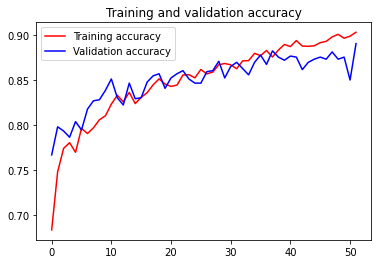

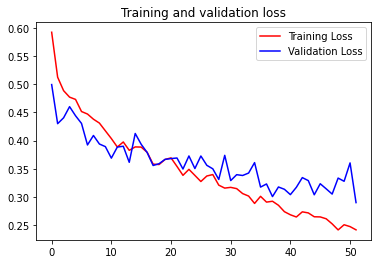

In [353]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [354]:
# Save model
model.save("./app/face_mask_detection_model.h5")

In [355]:
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1084 (Conv2D)        (None, 122, 122, 32)      896       
                                                                 
 max_pooling2d_572 (MaxPooli  (None, 24, 24, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_1085 (Conv2D)        (None, 22, 22, 64)        18496     
                                                                 
 conv2d_1086 (Conv2D)        (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_573 (MaxPooli  (None, 4, 4, 128)        0         
 ng2D)                                                           
                                                                 
 flatten_201 (Flatten)       (None, 2048)            

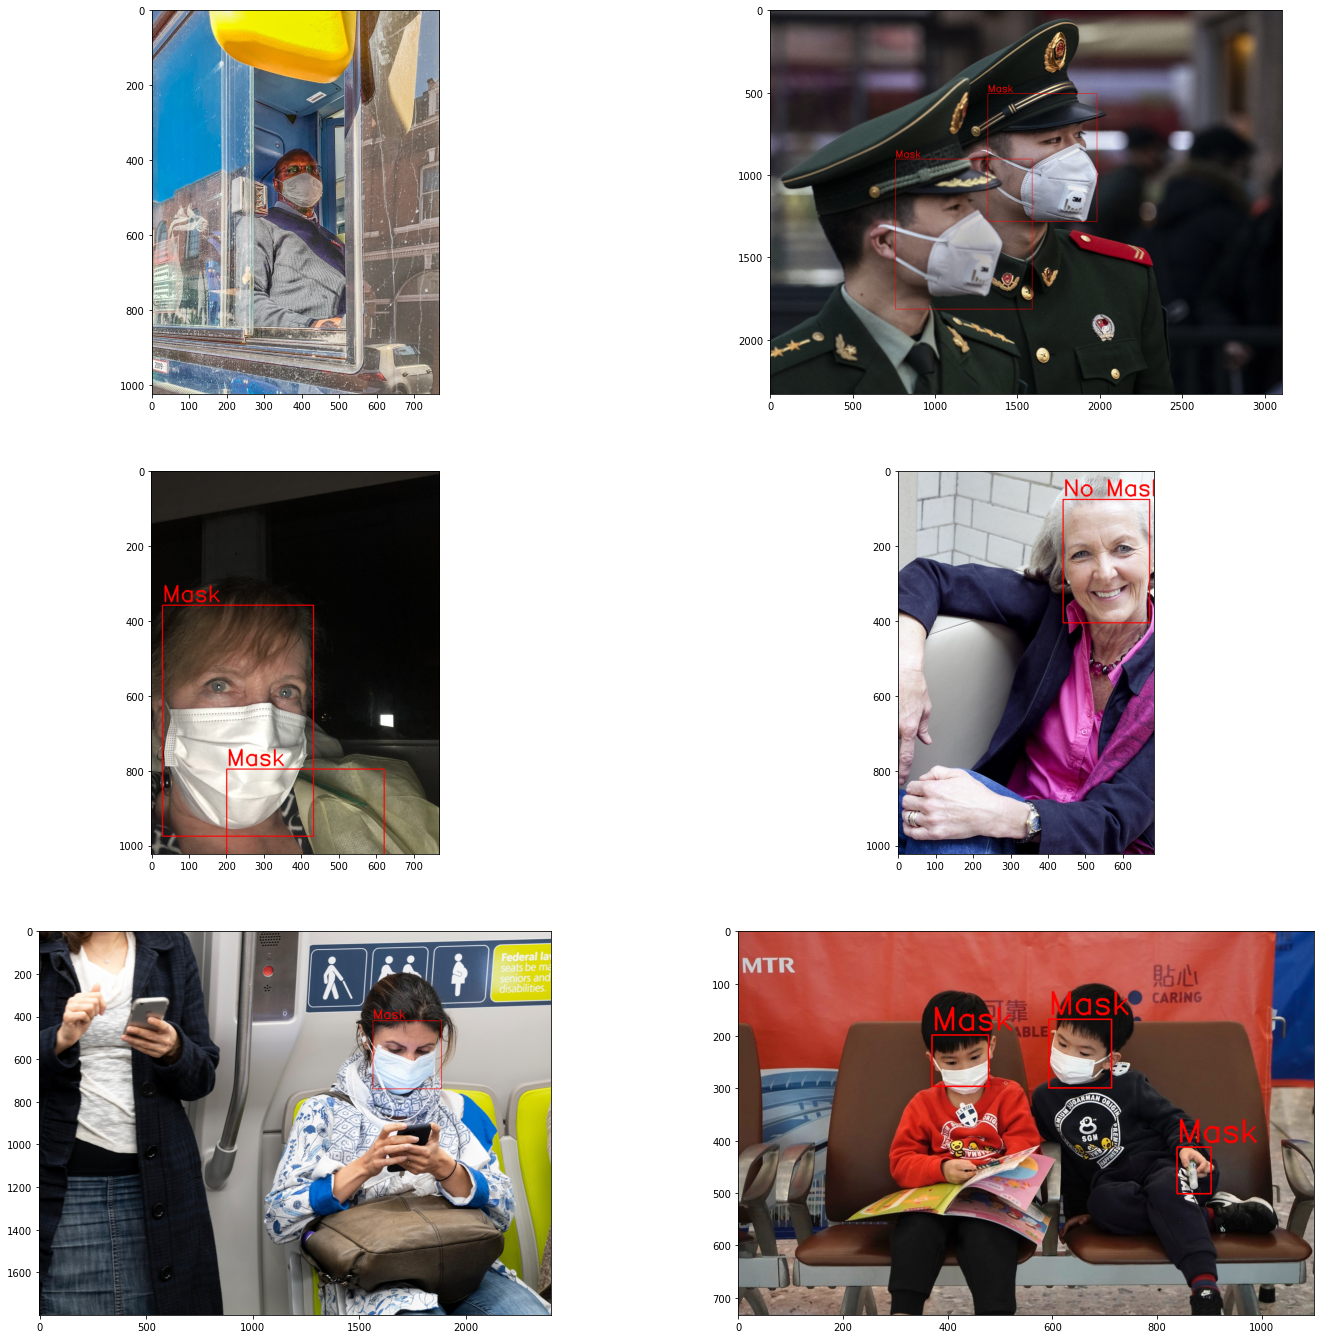

In [356]:
gamma = 2.0
img_size = (124,124)
fig = plt.figure(figsize = (24,24))
rows = 3
cols = 2
axes = []
assign = {'0':'No Mask','1':"Mask"}
for j,im in enumerate(X_test_list[0:6]):
    image =  cv2.imread(os.path.join(images,im),1)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.3:
                im = cv2.resize(frame,img_size)
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 4)

        except:
            pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

#### 5. Conclusion
By analyzing the output above, we can observe that the whole system works well for faces that have spatial dominance. But fails in the case of images where the faces are small and take up less space in the overall image.
The prediction of mask(1), no mask(0) of correctly identified faces is around 89%. The CNN model is at risk to overfit very easily. The model therefore is based on known elements like convolutions; but there is played around with Maxpooling2D, taking (5,5) instead of (2,2), which lowers the accuray of training, but prevents overfitting, together with the augmented image paramter.
88% is therefore an accepable value.